# Model Training

## Imports

In [1]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [2]:
# Reading in the csv
df = pd.read_csv("../cleaning/output_data/clean_house_crime_data.csv")
df.head()

,Rooms,Type,Price,Distance,Bathroom,Car,Landsize,Year,Month,Crime
0,2,h,1480000.0,2.5,1.0,1.0,202.0,2016,2,1053.0
1,2,h,1035000.0,2.5,1.0,0.0,156.0,2016,3,1053.0
2,4,h,1600000.0,2.5,1.0,2.0,120.0,2016,3,1053.0
3,2,h,941000.0,2.5,1.0,0.0,181.0,2016,6,1053.0
4,3,h,1876000.0,2.5,2.0,0.0,245.0,2016,6,1053.0


## Altering the dataframe

This model will be trained without the Landsize variable because landsize isn't consistently included in the property listings. This way, there will be a model for when landsize is included, and a model for when it is not available.  

In [3]:
# Dropping Landsize
df = df.drop(columns=['Landsize'])
df.head()

,Rooms,Type,Price,Distance,Bathroom,Car,Year,Month,Crime
0,2,h,1480000.0,2.5,1.0,1.0,2016,2,1053.0
1,2,h,1035000.0,2.5,1.0,0.0,2016,3,1053.0
2,4,h,1600000.0,2.5,1.0,2.0,2016,3,1053.0
3,2,h,941000.0,2.5,1.0,0.0,2016,6,1053.0
4,3,h,1876000.0,2.5,2.0,0.0,2016,6,1053.0


## Binary encoding


As the 'Type' column is categorical, it will need to be binary encoded before the model is created. This will replace the 'Type' column with three new columns, one for house, one for unit and one for townhouse. The columns will indicate whether a row is a unit, townhouse or house through the presence of a 1 in the appropriate columns and a 0 in the two columns that don't represent the property type.

In [4]:
# Creating a copy of the dataframe 
data = df.copy()

In [5]:
# Using pd.get_dummies to binary encode the 'Type' column
binary_encoded_df = pd.get_dummies(data, columns=["Type"])
binary_encoded_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,2,1480000.0,2.5,1.0,1.0,2016,2,1053.0,1,0,0
1,2,1035000.0,2.5,1.0,0.0,2016,3,1053.0,1,0,0
2,4,1600000.0,2.5,1.0,2.0,2016,3,1053.0,1,0,0
3,2,941000.0,2.5,1.0,0.0,2016,6,1053.0,1,0,0
4,3,1876000.0,2.5,2.0,0.0,2016,6,1053.0,1,0,0


## Scaling

As the input variables are currently in different units and have different scales this may affect the way the model learns and could result in different weight being placed on certain variables.

The variables will therefore be normalised before modelling. This will scale each input variable separately to a range between 0 and 1.

Following the method of scikit learn's MinMaxScaler, the variables will be scaled manually to ensure that the mimimums and maximums not only reflect the training data, but also the possible input data when the model is being used.


In [6]:
# Creating a copy of the dataframe 
scaling_df = binary_encoded_df.copy()
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,2,1480000.0,2.5,1.0,1.0,2016,2,1053.0,1,0,0
1,2,1035000.0,2.5,1.0,0.0,2016,3,1053.0,1,0,0
2,4,1600000.0,2.5,1.0,2.0,2016,3,1053.0,1,0,0
3,2,941000.0,2.5,1.0,0.0,2016,6,1053.0,1,0,0
4,3,1876000.0,2.5,2.0,0.0,2016,6,1053.0,1,0,0


### Rooms

In [8]:
# Checking min/max for rooms column
print(f"max: {scaling_df['Rooms'].max()}")
print(f"min: {scaling_df['Rooms'].min()}")

max: 12
min: 1


In [9]:
# Scaling rooms using the minimum and maximum
scaling_df['Rooms'] = (scaling_df['Rooms'] - 1)/(12-1)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,2.5,1.0,1.0,2016,2,1053.0,1,0,0
1,0.090909,1035000.0,2.5,1.0,0.0,2016,3,1053.0,1,0,0
2,0.272727,1600000.0,2.5,1.0,2.0,2016,3,1053.0,1,0,0
3,0.090909,941000.0,2.5,1.0,0.0,2016,6,1053.0,1,0,0
4,0.181818,1876000.0,2.5,2.0,0.0,2016,6,1053.0,1,0,0


### Distance

In [10]:
# Checking min/max for distance column
print(f"max: {scaling_df['Distance'].max()}")
print(f"min: {scaling_df['Distance'].min()}")

max: 48.1
min: 0.0


In [11]:
# Scaling distance using a mimumum of 0 and a maximum of 50
scaling_df['Distance'] = (scaling_df['Distance'] - 0)/(50-0)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,1.0,1.0,2016,2,1053.0,1,0,0
1,0.090909,1035000.0,0.05,1.0,0.0,2016,3,1053.0,1,0,0
2,0.272727,1600000.0,0.05,1.0,2.0,2016,3,1053.0,1,0,0
3,0.090909,941000.0,0.05,1.0,0.0,2016,6,1053.0,1,0,0
4,0.181818,1876000.0,0.05,2.0,0.0,2016,6,1053.0,1,0,0


### Bathroom

In [12]:
# Checking min/max for the Bathroom column
print(f"max: {scaling_df['Bathroom'].max()}")
print(f"min: {scaling_df['Bathroom'].min()}")

max: 9.0
min: 0.0


In [13]:
# Scaling Bathroom using the minimum and maximum
scaling_df['Bathroom'] = (scaling_df['Bathroom'] - 0)/(9-0)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,0.111111,1.0,2016,2,1053.0,1,0,0
1,0.090909,1035000.0,0.05,0.111111,0.0,2016,3,1053.0,1,0,0
2,0.272727,1600000.0,0.05,0.111111,2.0,2016,3,1053.0,1,0,0
3,0.090909,941000.0,0.05,0.111111,0.0,2016,6,1053.0,1,0,0
4,0.181818,1876000.0,0.05,0.222222,0.0,2016,6,1053.0,1,0,0


### Car

In [14]:
# Checking min/max for the Car column
print(f"max: {scaling_df['Car'].max()}")
print(f"min: {scaling_df['Car'].min()}")

max: 18.0
min: 0.0


In [15]:
# Scaling Car using the minimum and maximum
scaling_df['Car'] = (scaling_df['Car'] - 0)/(18-0)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,0.111111,0.055556,2016,2,1053.0,1,0,0
1,0.090909,1035000.0,0.05,0.111111,0.000000,2016,3,1053.0,1,0,0
2,0.272727,1600000.0,0.05,0.111111,0.111111,2016,3,1053.0,1,0,0
3,0.090909,941000.0,0.05,0.111111,0.000000,2016,6,1053.0,1,0,0
4,0.181818,1876000.0,0.05,0.222222,0.000000,2016,6,1053.0,1,0,0


### Year

In [16]:
# Checking min/max for the Year column
print(f"max: {scaling_df['Year'].max()}")
print(f"min: {scaling_df['Year'].min()}")

max: 2018
min: 2016


In [17]:
# Scaling Year using a maximum of 2024 so that we can test if the model can be predictive 
scaling_df['Year'] = (scaling_df['Year'] - 2016)/(2024-2016)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,0.111111,0.055556,0.0,2,1053.0,1,0,0
1,0.090909,1035000.0,0.05,0.111111,0.000000,0.0,3,1053.0,1,0,0
2,0.272727,1600000.0,0.05,0.111111,0.111111,0.0,3,1053.0,1,0,0
3,0.090909,941000.0,0.05,0.111111,0.000000,0.0,6,1053.0,1,0,0
4,0.181818,1876000.0,0.05,0.222222,0.000000,0.0,6,1053.0,1,0,0


### Month

In [18]:
# Checking min/max for the Month column
print(f"max: {scaling_df['Month'].max()}")
print(f"min: {scaling_df['Month'].min()}")

max: 11
min: 0


In [19]:
# Scaling Month using the minimum and maximum
scaling_df['Month'] = (scaling_df['Month'] - 0)/(11-0)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,0.111111,0.055556,0.0,0.181818,1053.0,1,0,0
1,0.090909,1035000.0,0.05,0.111111,0.000000,0.0,0.272727,1053.0,1,0,0
2,0.272727,1600000.0,0.05,0.111111,0.111111,0.0,0.272727,1053.0,1,0,0
3,0.090909,941000.0,0.05,0.111111,0.000000,0.0,0.545455,1053.0,1,0,0
4,0.181818,1876000.0,0.05,0.222222,0.000000,0.0,0.545455,1053.0,1,0,0


### Crime

In [20]:
# Checking min/max for the Crime column
print(f"max: {scaling_df['Crime'].max()}")
print(f"min: {scaling_df['Crime'].min()}")

max: 15485.0
min: 1.0


In [21]:
# Scaling Month using a minimum of 0 as this was the minimum of the 2020 data and the maximum found above
scaling_df['Crime'] = (scaling_df['Crime'] - 0)/(15485-0)
scaling_df.head()

,Rooms,Price,Distance,Bathroom,Car,Year,Month,Crime,Type_h,Type_t,Type_u
0,0.090909,1480000.0,0.05,0.111111,0.055556,0.0,0.181818,0.068001,1,0,0
1,0.090909,1035000.0,0.05,0.111111,0.000000,0.0,0.272727,0.068001,1,0,0
2,0.272727,1600000.0,0.05,0.111111,0.111111,0.0,0.272727,0.068001,1,0,0
3,0.090909,941000.0,0.05,0.111111,0.000000,0.0,0.545455,0.068001,1,0,0
4,0.181818,1876000.0,0.05,0.222222,0.000000,0.0,0.545455,0.068001,1,0,0


## Creating the model

The model used is XGBRegressor from the XGBoost library and is a gradient boosting decision tree algorithm. The model works by creating new models that predict the errors of previous models. These are then added together to made the actual prediction. These models are made and added sequentially to correct the errors of previous models until no more improvements can be made.

XGBoost stands for “Extreme Gradient Boosting” and was chosen as it is used for supervised problems and supports regression modelling with the XGBRegressor.

documentation: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [23]:
# Creating a copy of the dataframe  
model_df = scaling_df.copy()

In [24]:
# Assigning the X and y variables as columns from the dataframe
X = model_df.drop("Price", axis=1)
y = model_df['Price'].values.reshape(-1, 1)

In [25]:
# Randomly splitting the data into training and testing using train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14)

In [26]:
# Creating an instance of the XGBRegressor

model = xgboost.XGBRegressor()

In [27]:
# Fitting the training data to the model

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
# Checking the models r2 score for the training and testing data

print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.8552898286470026
Testing Data Score: 0.7177928446837885


In [29]:
# Obtaining the predictions for the testing data 
predictions = model.predict(X_test)
predictions

array([1924163.2 , 2421796.5 ,  330055.53, ..., 1523222.4 , 1521845.1 ,
       2356497.2 ], dtype=float32)

In [30]:
# Checking the mean squared error
MSE = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 116800384495.93686, R2: 0.7177928446837885


### Creating a dataframe of the y values and the predicted results

#### First, obtaining data in appropriate format

In [31]:
# Getting predictions out of array

final_prediction = []

x = 0

for i in predictions:
    
    value = round(predictions[x],0)
    final_prediction.append(value)
    
    x += 1

In [32]:
# getting y values out of array
y_values = []

x = 0

for y in y_test:
    
    value = y_test[x][0]
    y_values.append(value)
    
    x += 1

#### Creating the dataframe

In [33]:
# Creating a dataframe of the actual testing values and the predicted testing values
# Actual vs. prediction dataframe

actual_vs_prediction_df = pd.DataFrame({'Actual': y_values,'Prediction': final_prediction})
actual_vs_prediction_df

,Actual,Prediction
0,1077500.0,1924163.0
1,2200000.0,2421796.0
2,580000.0,330056.0
3,1190000.0,1396386.0
4,461000.0,411381.0
...,...,...
4344,715000.0,655854.0
4345,540000.0,562671.0
4346,1750000.0,1523222.0
4347,1650000.0,1521845.0


#### Plotting the results

Seeing how the actual values and the predictions look on a scatterplot, how accurate the predictions are and if a trend can be seen.

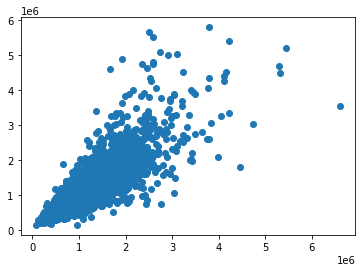

In [34]:
import matplotlib.pyplot as plt

plt.scatter(final_prediction, y_values)

## Hyperparameter optimisation

Will now be adjusting the hyperparameters to see if the model can be improved at all. 

In [35]:
# Creating a new instance of XGBRegressor
model_2 = xgboost.XGBRegressor()

In [36]:
# Checking the parameters that can be adjusted
model_2.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [37]:
# Setting a range of values for the chosen parameters
parameters = {'max_depth': [2,3,5,10,15], 
              'n_estimators':[100, 150,200,500,900,1200,1500], 
              'booster':['gbtree','gblinear'], 
              'learning_rate':[0.05,0.1,0.15,0.20],
              'min_child_weight':[1,2,3,4],
              'base_score':[0.25,0.5,0.75,1]}

Now using RandomizedSearchCV from sklearn which will sample a set number of parameter settings from the values specified above. The number of parameter settings that are tested is given by n_iter, so 50 settings in this case. The estimator is set as model_2, which is the instance of XGBRegressor. The parameters defined above are then passed into param_distributions. 


In [38]:
model_randomized = RandomizedSearchCV(estimator=model_2,
                               param_distributions=parameters,
                               cv=5,n_iter=50,
                               scoring='neg_mean_absolute_error',n_jobs=4,
                               verbose=5,
                               return_train_score=True,
                               random_state=42)

In [39]:
# Fitting the specified RandomizedSearchCV with the training data
# This runs through each setting so that the best combination of parameters can be found
model_randomized.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  5.4min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=4,
                   para

In [40]:
# Finding the best parameter values for this model
model_randomized.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
# Creating a new instance of XGBRegressor where the parameters are defined as the best estiators

best_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


# removed missing=nan because this produced an error

In [43]:
# Fitting the training data to the best identified model
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
# Checking the models r2 score for the training and testing data

print(f"Training Data Score: {best_model.score(X_train, y_train)}")
print(f"Testing Data Score: {best_model.score(X_test, y_test)}")

Training Data Score: 0.8360156574530111
Testing Data Score: 0.7338154551288684


In [45]:
# Comparing the Testing Data scores of this model and the previous model

print(f"Testing Data Score of original model: {model.score(X_test, y_test)}")
print(f"Testing Data Score of the tuned model: {best_model.score(X_test, y_test)}")
print(f"There has been an improvement of: {(best_model.score(X_test, y_test) - model.score(X_test, y_test)) *100}%")

Testing Data Score of original model: 0.7177928446837885
Testing Data Score of the tuned model: 0.7338154551288684
There has been an improvement of: 1.602261044507991%


In [46]:
# Obtaining the predictions for the testing data 
predictions = best_model.predict(X_test)
predictions

array([1877270.9 , 2218266.8 ,  405904.44, ..., 1492878.9 , 1425516.9 ,
       2512046.8 ], dtype=float32)

In [47]:
# Checking the mean squared error
MSE = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 110168918831.93907, R2: 0.7338154551288684


## Saving the Model

In [48]:
import joblib
joblib_file = "../models/model_without_landsize.joblib"
joblib.dump(best_model, joblib_file)

['../models/model_without_landsize.joblib']